## LSH(Locality Sensitive Hashing)
LSH算法是一个被广泛使用的ANN算法，它可以在保证质量较高的搜索结果的同时，仍然保持高效的搜索速度。我们在这一章会阐述LSH的原理，同时用python实现一个自己的LSH搜索引擎。

In [15]:
print('Welcome to LSH!')

Welcome to LSH!


### Prepare Data
如果你已经下载了数据，可以直接跳过这个cell

In [16]:
import shutil
import urllib.request as request
import tarfile
from contextlib import closing

# download the Sift1M dataset
with closing(request.urlopen('ftp://ftp.irisa.fr/local/texmex/corpus/siftsmall.tar.gz')) as r:
    with open('sift.tar.gz', 'wb') as f:
        shutil.copyfileobj(r, f)


# the download leaves us with a tar.gz file, we unzip it
tar = tarfile.open('sift.tar.gz', "r:gz")
tar.extractall()

在讲LSH算法之前，我们先回忆一下我们平时接触到的HASH算法。他们有以下几个特点
1. 如果两个元素完全相同(每个bit都一样),那么会产生相同的hashcode。
2. 如果两个元素哪怕只有一个bit不同，最后产生的hashcode也会相差较大。

但是这样的HASH算法并不适合我们的ANN搜索。举一个例子，比如说我们有下面两篇文档
> I like dog

> I really like dog

如果我们使用传统的hash算法，即使这两篇文档只差了一个**really**，仍旧会产生完全不同的hashcode
| doc | MD5 | SHA1 |
| --- | --- | ---- |
|I like dog| 8a8249c0591b1c9aacc86f7a7e62fec3 | cf8ddb14b51c85d344cc7d841be5963b60a6d1a6 |
|I really like dog| 28316b7215c792aeea598f132e9e9541 | f541e674f949f39a5c1df53e45b46f0b5d518820 |

这就意味着如果我们基于hash来进行搜索,当输入为`I like dog`时,我们无法检索到`I really like dog`,这显然不是我们所期望的。而LSH通过巧妙的方法，让我们可以通过基于hash的方式，来搜索到相似的文档。

LSH的主要思想可以归纳为
1. 如果两篇文档相似，那么让他们的hashcode尽可能的相同，即发生碰撞。
2. 如果两篇文档不相似，那么尽可能的让他们hashcode不相同。

为此，我们需要有一个hash函数可以满足上述的两个要求。常见的hash函数有**MinHash**、**Random Projection**和**Cosine Similarity Hashing**等。本章的后续篇幅主要介绍**Random Projection**

### Random Projection
为了便于理解，我们从一个三维的例子出发.


<div style="text-align: center">
<img src="./resources/lsh_1.png"/>
</div>

假设我们现在向量空间中有六个点，我们可以任意选择一个超平面，这个超平面会将整个向量空间一分为2.

<div style="text-align: center">
<img src="./resources/lsh_2.png"/>
</div>

从图中我们可以看到，点A，B，C，D处于超平面的正面，而点E，F则处于超平面的负面。因此我们可以将A，B，C，D的hashcode设置为1, 点E，F的hashcode设置为0。这种hash方式符合LSH的要求，即相似的向量hashcode相同。

````
Hash(A) = Hash(B)
Hash(C) = Hash(D)
Hash(E) = Hash(F)
````
但是LSH的第二个要求并不满足，我们的`Hash(A) == Hash(C)`, 根据要求,我们应该有`Hash(A) != Hash(C)`。为了解决这个问题，我们可以再多加一个超平面.

<div style="text-align: center">
<img src="./resources/lsh_3.png"/>
</div>

通过增加超平面的方式，我们可以将hashcode从一个比特变成两个比特,也完成了LSH的hash函数要求。
````
Hash(A) = Hash(B) = 10
Hash(C) = Hash(D) = 11
Hash(A) = Hash(B) = 01

````
上述的方法就是随机投影法。我们通过随机生成固定数量N的超平面后，根据向量是处在超平面的正面还是负面，将向量hash为Nbit的hashcode。这一方法符合直觉，如果两个点相似，即距离相近，那么通过随机投影，他们会有较高的概率拥有相同的hashcode，但如果相距较远，他们的拥有相同的hashcode概率也会较低。同时计算一个点在超平面的正面还是负面也相当简单，你只需要对他们做点积即可。
````python
if np.dot(a, hyper_plane.T) > 0:
    return 1
return 0 

````
因此我们可以低成本的计算出向量的hashcode。

然而随机投影仍然有一个问题，需要我们去解决，即考虑下图的情况,我们随机生成的超平面将C，D两点隔开，也就是说C，D的hashcode将会不同，这与我们之前的假设相违背，即相似的向量应该具有相同的hashcode

<div style="text-align: center">
<img src="./resources/lsh_final.png"/>
</div>

为了解决上述问题，我们在计算完所有点的hashcode后，将hashcode相同的点放入同一个bucket中。再次随机生成超平面，重新计算所有点的hashcode，再将hashcode相同的点放到新的bucket中。
如下图所示,我们通过不同的hash函数(随机投影)对向量计算hashcode。

<div style="text-align: center">
<img src="./resources/hash_process.png"/>
</div>

在搜索时，我们会使用对应的的hash函数(随机投影)得到查询向量的hashcode，并去对应的bucket中计算距离，最终得出结果，举个例子
假设我们有查询向量Q, K = 2
````
Hash1(Q) = 000
Hash2(Q) = 001

````
我们分别会去和Bucket1以及Bucket5中的向量计算向量距离，然后返回距离最近的两个。


### Lab

In [17]:
import numpy as np

"""
Utils for read database
"""
def read_fvecs(file: str) -> np.ndarray:
    fv = np.fromfile(file, dtype=np.float32)
    if fv.size == 0:
        return np.zeros((0, 0))
    dim = fv.view(np.int32)[0]
    return fv.reshape(-1, dim + 1)[:, 1:].copy().view('float32')


def read_ivecs(file: str) -> np.ndarray:
    ground_truth = np.fromfile(file, dtype=np.int32)
    if ground_truth.size == 0:
        return ground_truth.zeros((0, 0))
    d = ground_truth[0]
    return ground_truth.reshape(-1, d+1)[:, 1:].copy().view('int32')

In [21]:

import heapq
"""
generate all keys for nbits
example:
    n = 2
    all_keys(n) result is ['00', '01', '10', '11']
"""
def all_keys(n):
    total = 1 << n
    keys = []
    for i in range(total):
        binary = format(i, f'0{n}b')
        keys.append(binary)
    return keys

# load dataset
data_set = read_fvecs('./siftsmall/siftsmall_base.fvecs')
# load all query 
query = read_fvecs('./siftsmall/siftsmall_query.fvecs')


class LSH:
    """
        Locailty Sensitive Hash
    """

    def __init__(self, nbits, n_buckets, d) -> None:
        """
            nbits is hashcode's size
            n_buckets is bucket's number
            d is dim of vector
        """

        # hash function different bucket
        self.hashes = []

        # buckets map
        self.buckets = []
        self.nbits = nbits
        self.n_buckets = n_buckets
        self.d = d
        self.keys = all_keys(nbits)
        for i in range(n_buckets):
            # store the hash function
            self.hashes.append(np.random.rand(d, nbits) - .5)
            self.buckets.append({})
            for key in self.keys:
                self.buckets[i][key] = []

    def cal_hashcode(self, vec: np.ndarray, bucket: int) -> str:
        """
            calculate the hashcode of vec
        """
        result = np.dot(vec, self.hashes[bucket])
        result = result > 0
        hashcode = result.astype(int)
        return ''.join(map(str, hashcode))

    def distance(self, v: np.ndarray, u: np.ndarray) -> float:
        """
            Euclidean distance of v,u
        """
        dis = sum((x - y) ** 2 for x, y in zip(v, u)) ** .5
        return dis

    def add_vec(self, vec: np.ndarray, label: int) -> None:
        for i in range(self.n_buckets):
            hashcode = self.cal_hashcode(vec, i)
            self.buckets[i][hashcode].append(label)

    def topK(self, vec: np.ndarray, k=10) -> list:
        candidates = set()
        for i in range(self.n_buckets):
            hashcode = self.cal_hashcode(vec, i)
            for idx in range(len(self.buckets[i][hashcode])):
                candidates.add(self.buckets[i][hashcode][idx])

        topk = []
        for label in candidates:
            dist = self.distance(vec, data_set[label])
            if len(topk) < k:
                heapq.heappush(topk, (-1 * dist, label))
            elif -1 * dist > topk[0][0]:
                heapq.heappushpop(topk, (-1 * dist, label))
        topk = sorted(topk, reverse=True)
        result = []
        top_len = min(k, len(topk))
        for i in range(0, top_len):
            result.append(topk[i][1])

        return result

In [35]:
import time
ground_truth = np.fromfile(
    "./siftsmall/siftsmall_groundtruth.ivecs", dtype=np.int32)
d = ground_truth[0]
gt = ground_truth.reshape(-1, d+1)[:, 1:].copy().view('int32')

def intersection(lst1: list, lst2 : list) -> list:
    return set(lst1).intersection(lst2)

def k_recall(lsh, k = 10) -> tuple:
    recall = 0.0
    st = time.time()
    times = 0
    for query_idx in range(0, len(query), 10):
        times += 1
        result = lsh.topK(query[query_idx], k)
        recall += (len(intersection(result, gt[query_idx][:k])) / k)
    se = time.time()
    return (recall / times, (se - st) / times)

recalls = []
times = []
names = []
# generate graph
for nbits in range(2, 12, 2):
    for n_bucket in range(1, 8, 3):
        lsh = LSH(nbits, n_bucket, data_set.shape[1])
        for label in range(0, len(data_set)):
            lsh.add_vec(data_set[label], label)
        recall, t = k_recall(lsh, 10)
        recalls.append(recall)
        times.append(t)
        names.append(f'b{nbits}n{n_bucket}')
        print(f'nbits {nbits}, bucket {n_bucket}, recall {recall}, time {t}')

nbits 2, bucket 1, recall 0.42000000000000004, time 0.37821664810180666
nbits 2, bucket 4, recall 0.99, time 1.2195415019989013
nbits 2, bucket 7, recall 1.0, time 1.3173397302627563
nbits 4, bucket 1, recall 0.6700000000000002, time 0.43165481090545654
nbits 4, bucket 4, recall 0.95, time 0.7499078750610352
nbits 4, bucket 7, recall 0.9800000000000001, time 1.125858736038208
nbits 6, bucket 1, recall 0.45999999999999996, time 0.12742328643798828
nbits 6, bucket 4, recall 0.79, time 0.4155558109283447
nbits 6, bucket 7, recall 0.9800000000000001, time 0.857691478729248
nbits 8, bucket 1, recall 0.29, time 0.04829647541046143
nbits 8, bucket 4, recall 0.6900000000000001, time 0.16893219947814941
nbits 8, bucket 7, recall 0.9099999999999999, time 0.4242942571640015
nbits 10, bucket 1, recall 0.08, time 0.009987354278564453
nbits 10, bucket 4, recall 0.65, time 0.13208918571472167
nbits 10, bucket 7, recall 0.63, time 0.11308534145355224


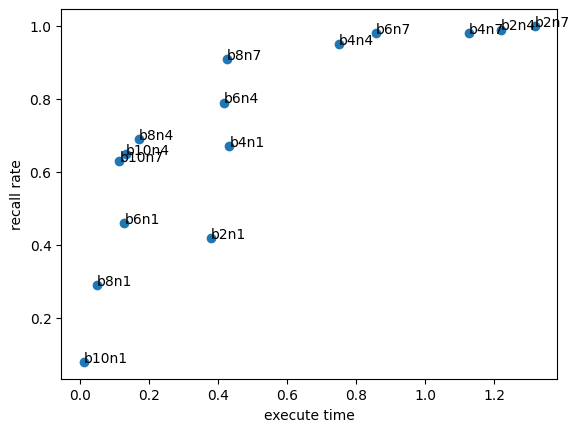

In [36]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.scatter(times, recalls)
for i, txt in enumerate(names):
    plt.annotate(txt, (times[i], recalls[i]))
plt.xlabel("execute time")
plt.ylabel("recall rate")
# 显示图形
plt.show()
